In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras

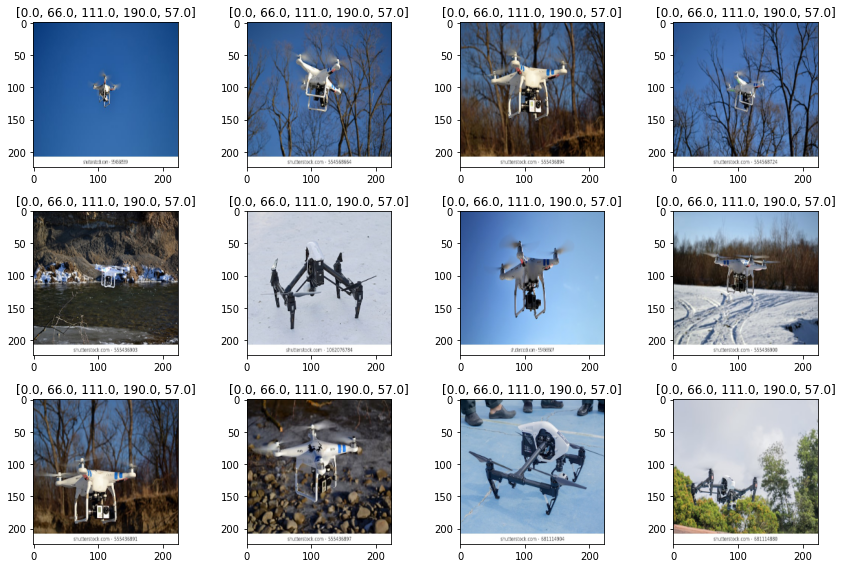

In [3]:
# Load the image dataset
images_path = '/content/gdrive/MyDrive/image'
images = []
for filename in os.listdir(images_path):
    img = plt.imread(os.path.join(images_path, filename))
    img = cv2.resize(img, (224, 224)) # Resize to (224, 224)
    images.append(img)
images = np.array(images, dtype=np.float32) / 255.0 # Normalize the pixel values to [0, 1]

# Load the label dataset
labels_path = '/content/gdrive/MyDrive/label'
labels = []
for filename in os.listdir(labels_path):
    with open(os.path.join(labels_path, filename)) as f:
        line = f.readline().split()
        label = [float(x) for x in line]
        labels.append(label)
labels = np.array(labels, dtype=np.float32)

# Plot the labels and verify the label format [x y width height]
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.ravel()
for i in range(12):
    axs[i].imshow(images[i])
    axs[i].set_title(label)
plt.tight_layout()
plt.show()

Split the data into training, validation, and testing sets

In [4]:
# training, validation, and testing sets - 8:1:1 
split_1 = len(images) * 0.8
split_2 = len(images) * 0.9

train_images, train_labels = images[:int(split_1)], labels[:int(split_1)]
val_images, val_labels = images[int(split_1):int(split_2)], labels[int(split_1):int(split_2)]
test_images, test_labels = images[int(split_2):], labels[int(split_2):]

MODEL 1 

Apply Pre-trained network from keras applications

In [5]:
model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layer
for layer in model.layers:
    layer.trainable = False

In [6]:
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
#x = keras.layers.Conv2D(128, (3, 3), activation='linear', padding='same')
#x = keras.layers.Conv2D(64, (3, 3), activation='linear', padding='same')
#x = keras.layers.BatchNormalization()
#x = keras.layers.LeakyReLU(alpha=0.1)
#x = keras.layers.MaxPooling2D((2, 2), padding='same')
predictions = keras.layers.Dense(5, activation='sigmoid')(x)

model = keras.models.Model(inputs=model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
# Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [8]:
# Train the model 
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
8/8 [==============================] - 26s 3s/step - loss: 17126.6016 - accuracy: 0.6932 - val_loss: 19331.8711 - val_accuracy: 0.6129
Epoch 2/10
8/8 [==============================] - 18s 2s/step - loss: 17105.1250 - accuracy: 0.5299 - val_loss: 19331.7520 - val_accuracy: 0.2258
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 17105.0879 - accuracy: 0.2908 - val_loss: 19331.7500 - val_accuracy: 0.3226
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 17105.0898 - accuracy: 0.3108 - val_loss: 19331.7500 - val_accuracy: 0.3226
Epoch 5/10
8/8 [==============================] - 14s 2s/step - loss: 17105.0898 - accuracy: 0.3506 - val_loss: 19331.7500 - val_accuracy: 0.3871
Epoch 6/10
8/8 [==============================] - 15s 2s/step - loss: 17105.0879 - accuracy: 0.3227 - val_loss: 19331.7500 - val_accuracy: 0.2903
Epoch 7/10
8/8 [==============================] - 15s 2s/step - loss: 17105.0879 - accuracy: 0.3466 - val_loss: 19331.7500 -

In [9]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Test loss: 16943.544921875
Test accuracy: 0.28125
